### Introduction

#### About Dataset:
We will be using rich dataset of amazon fine food reviews.

####  What are we trying to achieve??
We are going to tackle an interesting natural language processing problem i.e sentiment or text classification.
We will explore texual data using amazing spaCy library and build a text classification model.

### Here is breakdown of concepts I will try to explain.
We will extract linguistic features like 
1. tokenization,
1. part-of-speech tagging, 
1. dependency parsing, 
1. lemmatization , 
1. named entities recognition,
1. Sentence Boundary Detection	
for building language models later.

Visualizing Data
1. explacy - explaining how parsing is done
1. displaCy - visualizing named entities

Word vectors and similarity
1. sense2vec - using contextual information for building word embeddings

Text classification model
1. SpaCy TextCategorizer

### Loading data

In [1]:
import explacy
from IPython.display import IFrame
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example

import matplotlib.pyplot as plt

!pip install sense2vec
import sense2vec
from sense2vec import Sense2VecComponent

!pip install scattertext
import scattertext as st

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 859.6 kB/s eta 0:00:0000:0100:01
  Using cached flashtext-2.7-py2.py3-none-any.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 1.1 MB/s eta 0:00:0000:0100:01m


In [2]:
# Download trained text
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 900.4 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
!set -e
!unzip -o ../tests/data/Reviews.zip -d ../tests/data/

Archive:  ../tests/data/Reviews.zip
  inflating: ../tests/data/tests/data/Reviews.csv  


In [5]:
!tar -xvf ../tests/data/reddit_vectors-1.1.0.tar.gz --directory ../tests/data

x reddit_vectors-1.1.0/
x reddit_vectors-1.1.0/freqs.json
x reddit_vectors-1.1.0/meta.json
x reddit_vectors-1.1.0/strings.json
x reddit_vectors-1.1.0/vectors.bin


In [6]:
!tar -xvf ../tests/data/s2v_reddit_2015_md.tar.gz --directory ../tests/data

x ./s2v_old/
x ./s2v_old/freqs.json
x ./s2v_old/vectors
x ./s2v_old/cfg
x ./s2v_old/strings.json
x ./s2v_old/key2row


Let's read in food reviews data

In [7]:
food_reviews_df=pd.read_csv('./tests/data/Reviews.csv')
food_reviews_df.shape

(568454, 10)

In [8]:
food_reviews_df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
ProductId,B001E4KFG0,B00813GRG4,B000LQOCH0,B000UA0QIQ,B006K2ZZ7K
UserId,A3SGXH7AUHU8GW,A1D87F6ZCVE5NK,ABXLMWJIXXAIN,A395BORC6FGVXV,A1UQRSCLF8GW1T
ProfileName,delmartian,dll pa,"Natalia Corres ""Natalia Corres""",Karl,"Michael D. Bigham ""M. Wassir"""
HelpfulnessNumerator,1,0,1,3,0
HelpfulnessDenominator,1,0,1,3,0
Score,5,1,4,2,5
Time,1303862400,1346976000,1219017600,1307923200,1350777600
Summary,Good Quality Dog Food,Not as Advertised,"""Delight"" says it all",Cough Medicine,Great taffy
Text,I have bought several of the Vitality canned d...,Product arrived labeled as Jumbo Salted Peanut...,This is a confection that has been around a fe...,If you are looking for the secret ingredient i...,Great taffy at a great price. There was a wid...


Text column contains review given by customer.

Let's focus on texual data and ratings for text classification.

In [9]:
food_reviews_df = food_reviews_df[['Text','Score']].dropna()

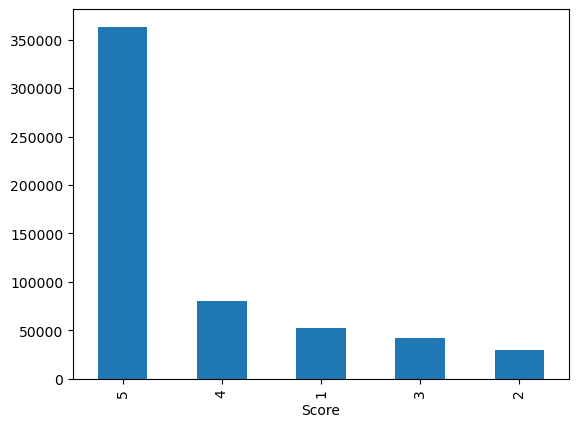

In [10]:
ax=food_reviews_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
fig.savefig("score.png");

We have five-star rating system.
It looks like we have more reviews with ratings 5, this can lead to unbalanced classes. We will treat rating 4 and 5 as positive and rest as negative reviews.

In [11]:
food_reviews_df.Score[food_reviews_df.Score<=3]=0
food_reviews_df.Score[food_reviews_df.Score>=4]=1

/var/folders/3n/7kvkbqjd0l9grdj7kptkcfgr0000gn/T/ipykernel_5138/1090184200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_reviews_df.Score[food_reviews_df.Score<=3]=0
/var/folders/3n/7kvkbqjd0l9grdj7kptkcfgr0000gn/T/ipykernel_5138/1090184200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_reviews_df.Score[food_reviews_df.Score>=4]=1


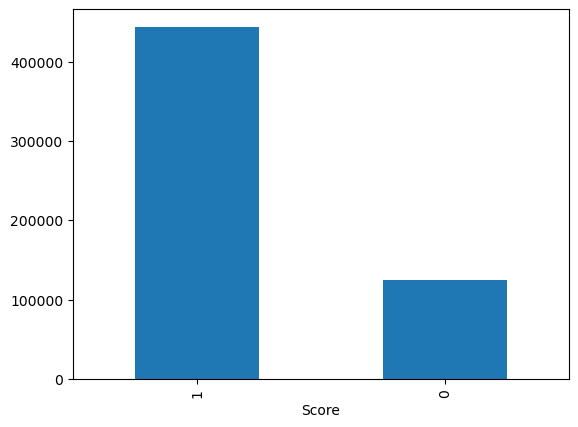

In [12]:
ax=food_reviews_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
fig.savefig("score_boolean.png");

In [13]:
food_reviews_df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


Since we have huge data, since it might be difficult to train in kernel, I will reduce data size of 100K rows.
To balance classes, i have selected equal samples from each class.

In [14]:
train_pos_df=food_reviews_df[food_reviews_df.Score==1][:50000]
train_neg_df=food_reviews_df[food_reviews_df.Score==0][:50000]

In [15]:
train_df=pd.concat([train_pos_df, train_neg_df])
train_df.shape

(100000, 2)

In [16]:
val_pos_df=food_reviews_df[food_reviews_df.Score==1][50000:60000]
val_neg_df=food_reviews_df[food_reviews_df.Score==0][50000:60000]
val_df=pd.concat([val_pos_df, val_neg_df])
val_df.shape

(20000, 2)

### Linguistic features

#### Tokenization
First step in any nlp pipeline is tokenizing text i.e breaking down paragraphs into sentenses and then sentenses into words, punctuations and so on.

we will load english language model to tokenize our english text.

Every language is different and have different rules. Spacy offers 8 different language models.

In [17]:
spacy.info('en_core_web_sm')

{'lang': 'en',
 'name': 'core_web_sm',
 'version': '3.7.1',
 'description': 'English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.',
 'author': 'Explosion',
 'email': 'contact@explosion.ai',
 'url': 'https://explosion.ai',
 'license': 'MIT',
 'spacy_version': '>=3.7.2,<3.8.0',
 'spacy_git_version': 'bd2c17e20',
 'vectors': {'width': 0, 'vectors': 0, 'keys': 0, 'name': None},
 'labels': {'tok2vec': [],
  'tagger': ['$',
   "''",
   ',',
   '-LRB-',
   '-RRB-',
   '.',
   ':',
   'ADD',
   'AFX',
   'CC',
   'CD',
   'DT',
   'EX',
   'FW',
   'HYPH',
   'IN',
   'JJ',
   'JJR',
   'JJS',
   'LS',
   'MD',
   'NFP',
   'NN',
   'NNP',
   'NNPS',
   'NNS',
   'PDT',
   'POS',
   'PRP',
   'PRP$',
   'RB',
   'RBR',
   'RBS',
   'RP',
   'SYM',
   'TO',
   'UH',
   'VB',
   'VBD',
   'VBG',
   'VBN',
   'VBP',
   'VBZ',
   'WDT',
   'WP',
   'WP$',
   'WRB',
   'XX',
   '_SP',
   '``'],
  'parser': ['ROOT',
   'acl',
   'acomp',


In [18]:
spacy_tok = spacy.load('en_core_web_sm')
sample_review=food_reviews_df.Text[54]
sample_review

"I roast at home with a stove-top popcorn popper (but I do it outside, of course). These beans (Coffee Bean Direct Green Mexican Altura) seem to be well-suited for this method. The first and second cracks are distinct, and I've roasted the beans from medium to slightly dark with great results every time. The aroma is strong and persistent. The taste is smooth, velvety, yet lively."

In [19]:
parsed_review = spacy_tok(sample_review)
parsed_review

I roast at home with a stove-top popcorn popper (but I do it outside, of course). These beans (Coffee Bean Direct Green Mexican Altura) seem to be well-suited for this method. The first and second cracks are distinct, and I've roasted the beans from medium to slightly dark with great results every time. The aroma is strong and persistent. The taste is smooth, velvety, yet lively.

There is not much difference between parsed review and original one. But we will see ahead what has actually happened.
We can see how parsing has been done visually through **explacy**.

In [20]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py

--2023-12-01 11:09:41--  https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6896 (6.7K) [text/plain]
Saving to: ‘explacy.py.4’

explacy.py.4        100%[===================>]   6.73K  --.-KB/s    in 0.002s  

2023-12-01 11:09:41 (2.72 MB/s) - ‘explacy.py.4’ saved [6896/6896]



In [21]:
explacy.print_parse_info(spacy_tok, 'The salad was surprisingly tasty.')

Dep tree Token        Dep type Lemma        Part of Sp
──────── ──────────── ──────── ──────────── ──────────
    ┌─►  The          det      the          DET       
 ┌─►└──  salad        nsubj    salad        NOUN      
┌┼─────  was          ROOT     be           AUX       
││  ┌─►  surprisingly advmod   surprisingly ADV       
│└─►└──  tasty        acomp    tasty        ADJ       
└─────►  .            punct    .            PUNCT     


In [22]:
explacy.print_parse_info(spacy_tok,food_reviews_df.Text[0])

Dep tree             Token       Dep type Lemma      Part of Sp
──────────────────── ─────────── ──────── ────────── ──────────
                ┌──► I           nsubj    I          PRON      
                │┌─► have        aux      have       AUX       
┌┬┬┬────────────┴┴── bought      ROOT     buy        VERB      
│││└─►┌───────────── several     dobj     several    ADJ       
│││   └─►┌────────── of          prep     of         ADP       
│││      │  ┌──────► the         det      the        DET       
│││      │  │    ┌─► Vitality    npadvmod Vitality   PROPN     
│││      │  │┌──►└── canned      amod     can        VERB      
│││      │  ││   ┌─► dog         compound dog        NOUN      
│││      │  ││┌─►└── food        compound food       NOUN      
│││      └─►└┴┴───── products    pobj     product    NOUN      
││└────────────────► and         cc       and        CCONJ     
││               ┌─► have        aux      have       AUX       
│└─────►┌────────┴── found       conj   

#### Part-of-speech tagging
After tokenization we can parse and tag variety of parts of speech to paragraph text. SpaCy uses statistical models in background to predict which tag will go for each word(s) based on the context.

##### Lemmatization
It is the process of extracting uninflected/base form of the word.
Lemma can be like
For eg. 

Adjectives: best, better → good
Adverbs: worse, worst → badly
Nouns: ducks, children → duck, child
Verbs: standing,stood → stand


In [23]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:20]

/var/folders/3n/7kvkbqjd0l9grdj7kptkcfgr0000gn/T/ipykernel_5138/30096977.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
/var/folders/3n/7kvkbqjd0l9grdj7kptkcfgr0000gn/T/ipykernel_5138/30096977.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tokenized_text.loc[i, 'is_stop'] = token.is_stop
/var/folders/3n/7kvkbqjd0l9grdj7kptkcfgr0000gn/T/ipykernel_5138/30096977.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tokenized_text

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,I,"(I,)",PRON,PRP,nsubj,X,True,True,False
1,roast,"(roast,)",VERB,VBP,ROOT,xxxx,True,False,False
2,at,"(at,)",ADP,IN,prep,xx,True,True,False
3,home,"(home,)",NOUN,NN,pobj,xxxx,True,False,False
4,with,"(with,)",ADP,IN,prep,xxxx,True,True,False
5,a,"(a,)",DET,DT,det,x,True,True,False
6,stove,"(stove,)",NOUN,NN,nmod,xxxx,True,False,False
7,-,"(-,)",PUNCT,HYPH,punct,-,False,False,True
8,top,"(top,)",NOUN,NN,pobj,xxx,True,True,False
9,popcorn,"(popcorn,)",NOUN,NN,compound,xxxx,True,False,False


#### Named Entity Recognition (NER)
Named entity is real world object like Person, Organization etc

Spacy figures out below entities automatically:

|Type	|Description|
|------|------|
|PERSON|	People, including fictional.
|NORP|	Nationalities or religious or political groups.|
|FAC|	Buildings, airports, highways, bridges, etc.|
|ORG|	Companies, agencies, institutions, etc.|
|GPE|	Countries, cities, states.|
|LOC|	Non-GPE locations, mountain ranges, bodies of water.|
|PRODUCT|	Objects, vehicles, foods, etc. (Not services.)|
|EVENT|	Named hurricanes, battles, wars, sports events, etc.|
|WORK_OF_ART|	Titles of books, songs, etc.|
|LAW|	Named documents made into laws.|
|LANGUAGE|	Any named language.|
|DATE|	Absolute or relative dates or periods.|
|TIME|	Times smaller than a day.|
|PERCENT|	Percentage, including "%".|
|MONEY|	Monetary values, including unit.|
|QUANTITY|	Measurements, as of weight or distance.|
|ORDINAL|	"first", "second", etc.|
|CARDINAL|	Numerals that do not fall under another type|

In [24]:
spacy.displacy.render(parsed_review, style='ent', jupyter=True)

In [25]:
spacy.explain('GPE') # to explain POS tag

'Countries, cities, states'

#### Dependency parsing
Syntactic Parsing or Dependency Parsing is process of identifyig sentenses and assigning a syntactic structure to it.
As in Subject combined with object makes a sentence.
Spacy provides parse tree which can be used to generate this structure.

##### Sentense Boundry Detection
Figuring out where sentense starts and ends is very imporatnt part of nlp.

In [26]:
sentence_spans = list(parsed_review.sents)
sentence_spans

[I roast at home with a stove-top popcorn popper (but I do it outside, of course).,
 These beans (Coffee Bean Direct Green Mexican Altura) seem to be well-suited for this method.,
 The first and second cracks are distinct, and I've roasted the beans from medium to slightly dark with great results every time.,
 The aroma is strong and persistent.,
 The taste is smooth, velvety, yet lively.]

In [27]:
displacy.render(parsed_review, style='dep', jupyter=True,options={'distance': 140})

Kindly scroll down if you can't see the output above.
You can even customize dependency parser's output as below.

In [28]:
options = {'compact': True, 'bg': 'violet','distance': 140,
           'color': 'white', 'font': 'Trebuchet MS'}
displacy.render(parsed_review, jupyter=True, style='dep', options=options)

In [29]:
spacy.explain("ADJ") ,spacy.explain("det") ,spacy.explain("ADP") ,spacy.explain("prep")  # to understand tags

('adjective', 'determiner', 'adposition', 'prepositional modifier')

#### Processing Noun chunks

In [30]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,I,"(I,)","(I,)",nsubj,roast
1,home,"(home,)","(home,)",pobj,at
2,top,"(top,)","(top,)",pobj,stove
3,I,"(I,)","(I,)",nsubj,do
4,it,"(it,)","(it,)",dobj,do
5,course,"(course,)","(course,)",pobj,of
6,These beans,"(beans,)","(beans,)",nsubj,seem
7,Coffee Bean Direct Green Mexican Altura,"(Altura,)","(Altura,)",appos,beans
8,this method,"(method,)","(method,)",pobj,for
9,The first and second cracks,"(cracks,)","(cracks,)",nsubj,are


### Visualizing using Scattertext

In [31]:
nlp = spacy.load('en_core_web_sm',disable=["tagger","ner"])

In [32]:
nlp = spacy.load('en_core_web_sm',disable=["tagger","ner"])
train_df['parsed'] = train_df.Text[49500:50500].apply(nlp)
corpus = st.CorpusFromParsedDocuments(train_df[49500:50500],
                             category_col='Score',
                             parsed_col='parsed').build()

/Users/facts/mambaforge/envs/text_classification/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [33]:
html = st.produce_scattertext_explorer(corpus,
          category="1",
          category_name='Positive',
          not_category_name='Negative',
          width_in_pixels=700,
          minimum_term_frequency=15,
          term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
          )

In [34]:
# uncomment this cell to load the interactive scattertext visualisation
filename = "positive-vs-negative.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 900, height=900)


### Word vectors and similarity

Ok let's do some modelling and focus on scoring our food!!

### Sence2vec

The idea is get something better than word2vec model.

The idea behind sense2vec is super simple. If the problem is that duck as in waterfowl and duck as in crouch are different concepts, the straight-forward solution is to just have two entries, duckN and duckV.  Trask et al (2015) published a nice set of experiments showing that the idea worked well.

It assight parts of speech tags like verb, noun , adjective to words, which will in turn be used to make sence of context.
1. Please book [VERB] my ticket.
2. Read the book [NOUN].

Read more [here](https://explosion.ai/blog/sense2vec-with-spacy) and [here](https://github.com/explosion/sense2vec)

Reddit talks about food a lot so we can get nice similarity vectors for food items.

In [35]:
# s2v = Sense2VecComponent('../test/data/reddit_vectors-1.1.0/')
s2v = spacy_tok.add_pipe('sense2vec')
s2v.from_disk('../tests/data/s2v_old/')
doc = spacy_tok(u"dessert.")
freq = doc[0]._.s2v_freq
vector = doc[0]._.s2v_vec
most_similar = doc[0]._.s2v_most_similar(5)
most_similar,freq

([(('desserts', 'NOUN'), 0.9013),
  (('cheesecake', 'NOUN'), 0.8898),
  (('appetizer', 'NOUN'), 0.8858),
  (('ice cream', 'NOUN'), 0.8813),
  (('chocolate cake', 'NOUN'), 0.8775)],
 15002)

In [36]:
doc = spacy_tok(u"burger")
most_similar = doc[0]._.s2v_most_similar(4)
most_similar

[(('sandwich', 'NOUN'), 0.9264),
 (('fries', 'NOUN'), 0.9241),
 (('hamburger', 'NOUN'), 0.9185),
 (('sandwhich', 'NOUN'), 0.9182)]

In [37]:
doc = spacy_tok(u"sandwich")
most_similar = doc[0]._.s2v_most_similar(4)
most_similar

[(('sandwhich', 'NOUN'), 0.9617),
 (('bagel', 'NOUN'), 0.9355),
 (('burger', 'NOUN'), 0.9264),
 (('burrito', 'NOUN'), 0.925)]

Similarity between entities can be kind of fun.


The following attributes are available via the ._ property – for example token._.in_s2v:

Name	|Attribute Type|	Type|	Description|
--------|---------------|-------------|---------------|
in_s2v	|property|	bool|	Whether a key exists in the vector map.
s2v_freq|	property|	int|	The frequency of the given key.
s2v_vec|	property|	ndarray[float32]|	The vector of the given key.
s2v_most_similar|	method|	list|	Get the n most similar terms. Returns a list of ((word, sense), score) tuples.



## SpaCy Text Categorizer

We will train a multi-label convolutional neural network text classifier on our food reviews, using spaCy's new TextCategorizer  component.

SpaCy provides classification model with multiple, non-mutually exclusive labels. You can change the model architecture rather easily, but by default, the TextCategorizer class uses a convolutional neural network to assign position-sensitive vectors to each word in the document. The TextCategorizer uses its own CNN model, to avoid sharing weights with the other pipeline components. The document tensor is then summarized by concatenating max and mean pooling, and a multilayer perceptron is used to predict an output vector of length nr_class, before a logistic activation is applied elementwise. The value of each output neuron is the probability that some class is present.

#### Prepare data
Let's prepare the data as SpaCy would like it.
It accepts list of tuples of text and labels.

In [38]:
train_df['tuples'] = train_df.apply(
    lambda row: (row['Text'],row['Score']), axis=1)
train = train_df['tuples'].tolist()
train[:1]

[('I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
  1)]

In [39]:
train[-2:]

[("I ordered this product specifically to try out the three different types of products. However, when I received the product, I opened it up only to find three of the Barn Burner salsas - obviously not what I had ordered.<br /><br />Buy at your own risk - who knows what you'll end up getting.",
  0),
 ('Terrific - easy to use and great taste.  Only complaint is that the price is MUCH too high.',
  0)]

In [40]:
#functions from spacy documentation
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y),
             'NEGATIVE': not bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=30000
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10

In [41]:
# nlp = spacy.load('en_core_web_sm') 
nlp = spacy.blank('en')  # create english Language class

In [42]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.add_pipe('textcat', last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('POSITIVE')
textcat.add_label('NEGATIVE')

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading food reviews data...
Using 30000 examples (24000 training, 6000 evaluation)


### Training model

In [43]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            for text, annotations in batch:
                # Create example
                doc = nlp.make_doc(text)
                doc_example = Example.from_dict(doc, annotations)
                nlp.update([doc_example], 
                           sgd=optimizer, 
                           drop=0.2,
                           losses=losses)
        print(f"Iteration: {i}\t Losses: {losses}")
        # with textcat.model.use_params(optimizer.averages):
        #     # evaluate on the dev data split off in load_data()
        #     scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        # print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
        #       .format(losses['textcat'], scores['textcat_p'],
        #               scores['textcat_r'], scores['textcat_f']))


Training the model...
LOSS 	  P  	  R  	  F  
Iteration: 0	 Losses: {'textcat': 4712.739235959461}
Iteration: 1	 Losses: {'textcat': 3409.733712078615}
Iteration: 2	 Losses: {'textcat': 3069.7149890158257}
Iteration: 3	 Losses: {'textcat': 2768.27316985431}
Iteration: 4	 Losses: {'textcat': 2625.454102989329}
Iteration: 5	 Losses: {'textcat': 2543.2628480295734}
Iteration: 6	 Losses: {'textcat': 2475.733136554003}
Iteration: 7	 Losses: {'textcat': 2367.392889327294}
Iteration: 8	 Losses: {'textcat': 2378.0707089873863}
Iteration: 9	 Losses: {'textcat': 2359.001470049523}


In [44]:
# test the trained model
test_text1 = 'This tea is fun to watch as the flower expands in the water. Very smooth taste and can be used again and again in the same day. If you love tea, you gotta try these "flowering teas"'
test_text2="I bought this product at a local store, not from this seller.  I usually use Wellness canned food, but thought my cat was bored and wanted something new.  So I picked this up, knowing that Evo is a really good brand (like Wellness).<br /><br />It is one of the most disgusting smelling cat foods I've ever had the displeasure of using.  I was gagging while trying to put it into the bowl.  My cat took one taste and walked away, and chose to eat nothing until I replaced it 12 hours later with some dry food.  I would try another flavor of their food - since I know it's high quality - but I wouldn't buy the duck flavor again."
doc = nlp(test_text1)
test_text1, doc.cats

('This tea is fun to watch as the flower expands in the water. Very smooth taste and can be used again and again in the same day. If you love tea, you gotta try these "flowering teas"',
 {'POSITIVE': 0.9955136179924011, 'NEGATIVE': 0.0044863782823085785})

Positive review is indeed close to 1

In [45]:
doc2 = nlp(test_text2)
test_text2, doc2.cats

("I bought this product at a local store, not from this seller.  I usually use Wellness canned food, but thought my cat was bored and wanted something new.  So I picked this up, knowing that Evo is a really good brand (like Wellness).<br /><br />It is one of the most disgusting smelling cat foods I've ever had the displeasure of using.  I was gagging while trying to put it into the bowl.  My cat took one taste and walked away, and chose to eat nothing until I replaced it 12 hours later with some dry food.  I would try another flavor of their food - since I know it's high quality - but I wouldn't buy the duck flavor again.",
 {'POSITIVE': 0.004218291025608778, 'NEGATIVE': 0.9957817792892456})

Negative review is close to 0

In [46]:
output_dir=%pwd
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Saved model to /Users/facts/Documents/workspaces/github/unt/csce_5214/projects/project_2/text_classification/notebooks


In [47]:
# test the saved model
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
doc2 = nlp2(test_text2)
print(test_text2, doc2.cats)

Loading from /Users/facts/Documents/workspaces/github/unt/csce_5214/projects/project_2/text_classification/notebooks
I bought this product at a local store, not from this seller.  I usually use Wellness canned food, but thought my cat was bored and wanted something new.  So I picked this up, knowing that Evo is a really good brand (like Wellness).<br /><br />It is one of the most disgusting smelling cat foods I've ever had the displeasure of using.  I was gagging while trying to put it into the bowl.  My cat took one taste and walked away, and chose to eat nothing until I replaced it 12 hours later with some dry food.  I would try another flavor of their food - since I know it's high quality - but I wouldn't buy the duck flavor again. {'POSITIVE': 0.004218291025608778, 'NEGATIVE': 0.9957817792892456}


In [52]:
nlp.to_disk("/Users/facts/Documents/workspaces/github/unt/csce_5214/projects/project_2/text_classification/docker/spacy")
doc3 = nlp2(test_text2)
doc3.cats

{'POSITIVE': 0.004218291025608778, 'NEGATIVE': 0.9957817792892456}

Model looks preety good. We can definitely improve it further by feeding more data and data augmentations.
Thanks for reading. Hope you learnt something new :)  #TODO Data Augmentation.